In [163]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict

In [26]:
# read csv/excel data files 
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')
pnas_data2 = pd.read_csv('/home/jaeweon/research/data/pnas_data2.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [146]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = pnas_data1.loc[:, features].values
scaled = StandardScaler().fit_transform(data_mat)
P, D, Q = svd(scaled)
data = np.matmul(scaled, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix
not_scaled = np.matmul(data_mat, Q.T)

In [6]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

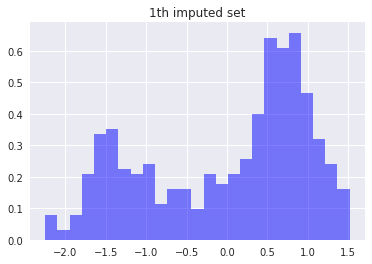

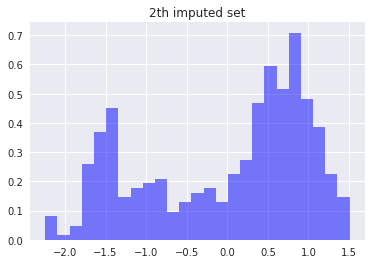

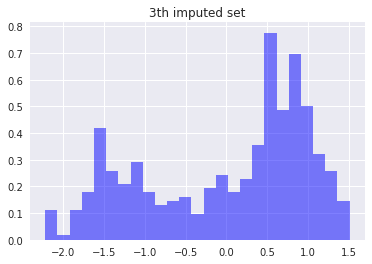

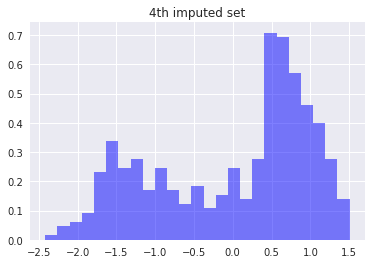

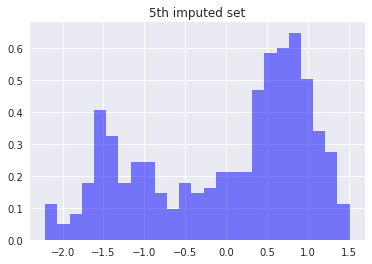

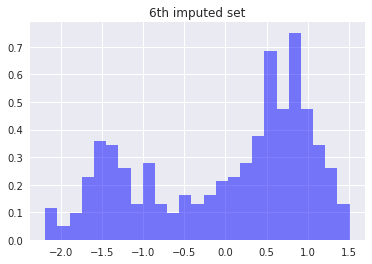

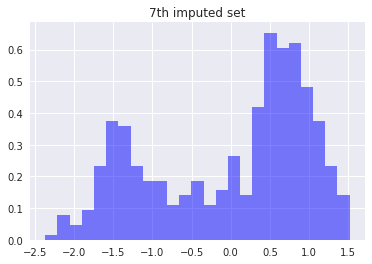

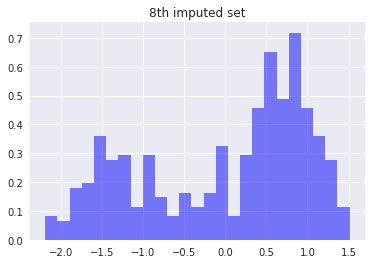

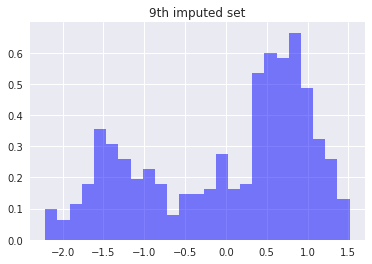

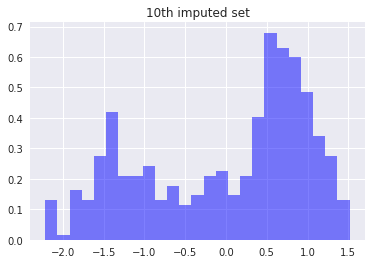

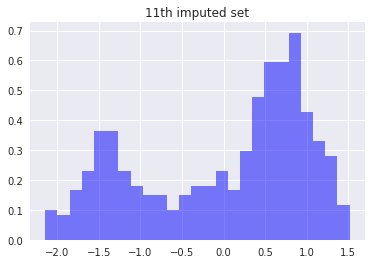

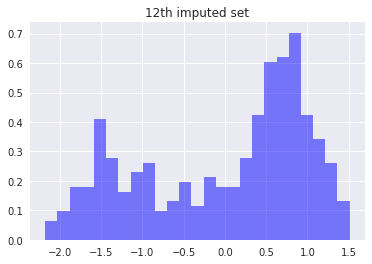

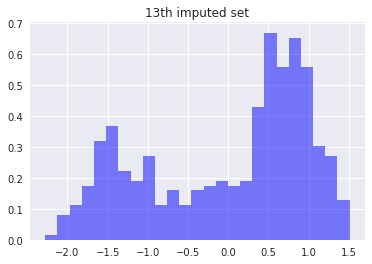

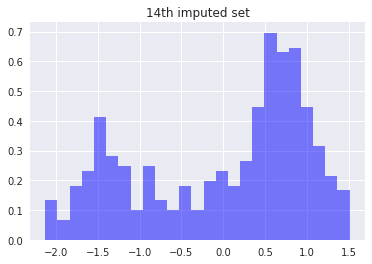

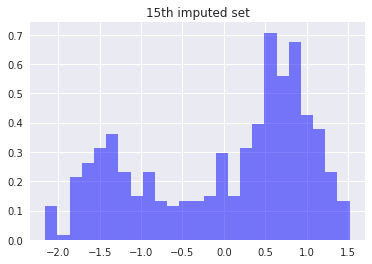

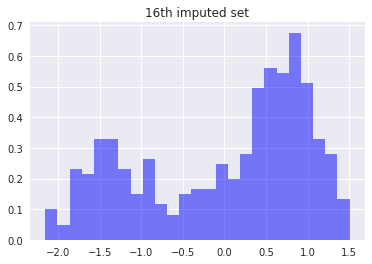

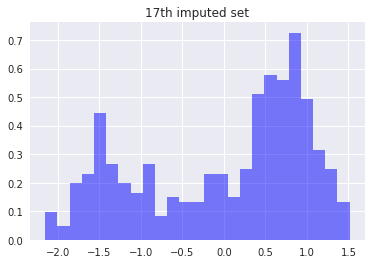

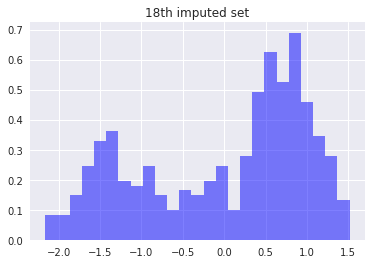

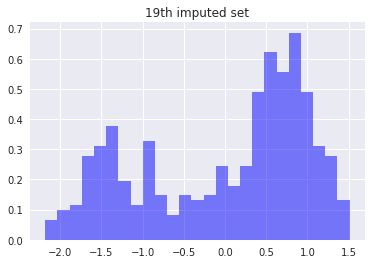

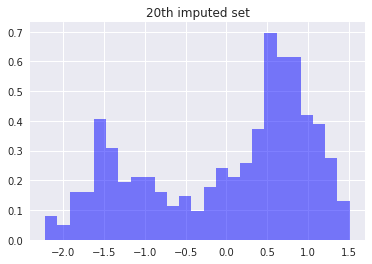

In [8]:
# histogram based on pca values for each of the imputed set
impute = ['V'+str(i) for i in range(1, 21)]

for i in range(len(impute)):
    data2 = StandardScaler().fit_transform(pnas_data2.loc[:, [impute[i]]].values)
    # filtered_pnas1 = pnas_data1.loc[:, features].values
    num_bins = 25

    # the histogram/gaussian mixture model of the data
    n, bins, patches = plt.hist(data2, num_bins, normed=1, facecolor='blue', alpha=0.5)
    
    plt.title(str(i+1)+"th imputed set")
    plt.legend()
    plt.show()
    plt.close()

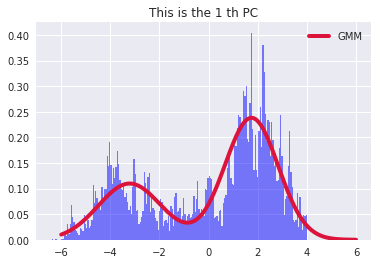

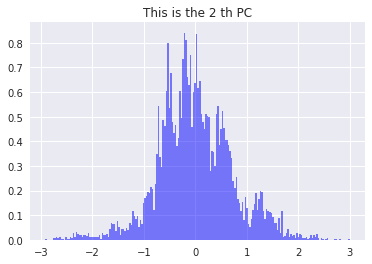

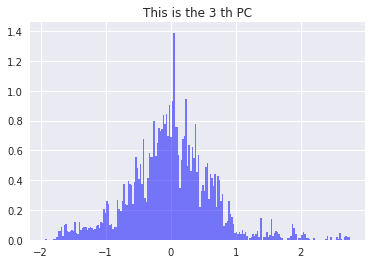

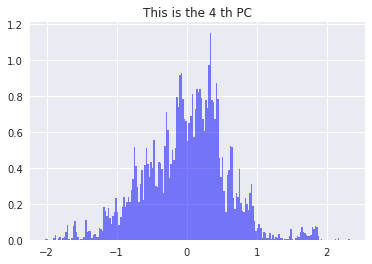

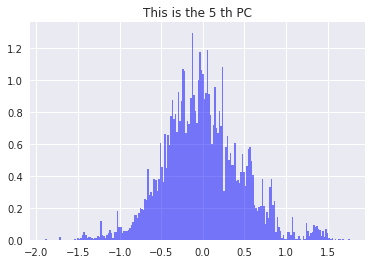

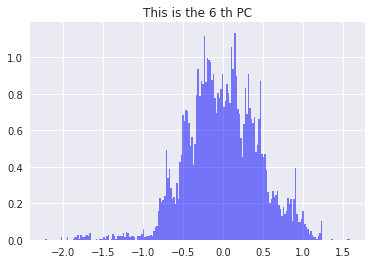

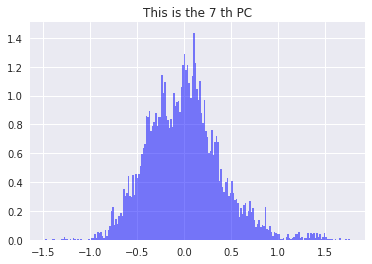

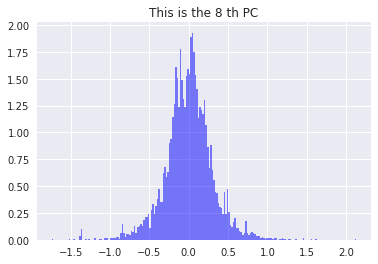

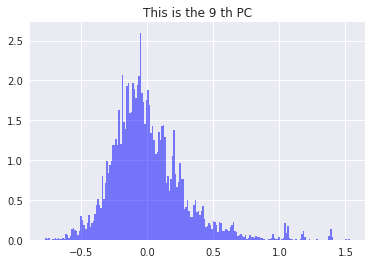

In [29]:
# histogram for 20 imputed sets combined 

num_bins = 200
mu = 0 # mean (data is centered)

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# Evaluate GMM
gmm_x = np.linspace(-6, 6, 200)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# the histogram/gaussian mixture model of the data for each of the principal component
for i in range(9):
    if i == 0:
        fig, ax = plt.subplots()
        ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

    n, bins, patches = plt.hist(data[:,i], num_bins, normed=1, facecolor='blue', alpha=0.5)

    plt.title('This is the %s th PC'% str(int(i)+1))
    plt.legend()
    plt.show()
    plt.close()

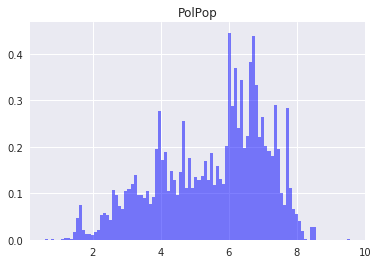

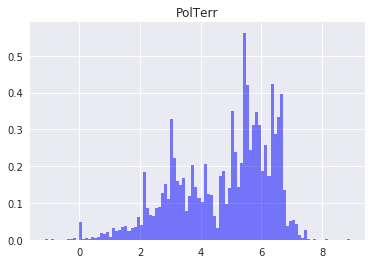

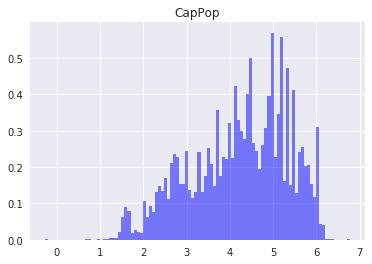

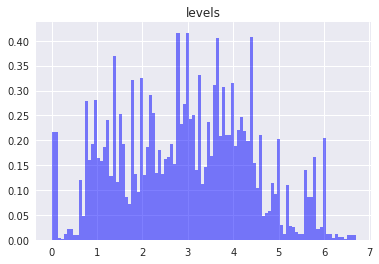

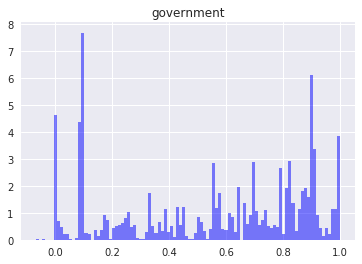

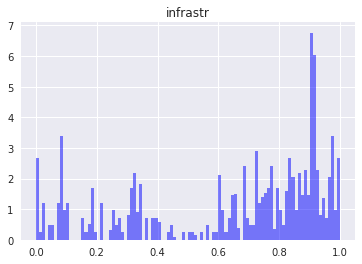

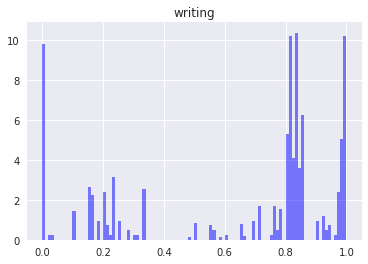

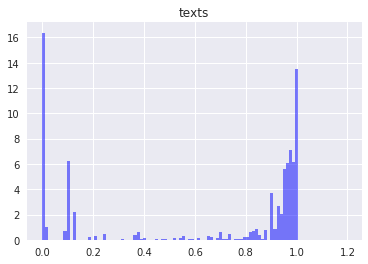

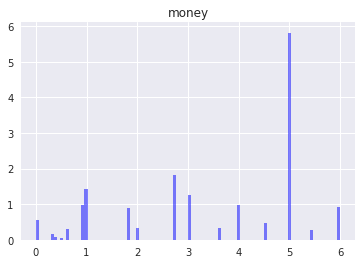

In [29]:
# histogram for each CCs

num_bins = 100

for cc in range(9): 
    n, bins, patches = plt.hist(data_mat[:, cc], num_bins, normed=1, facecolor='blue', alpha=0.5)
    plt.title(features[cc])
    plt.legend()
    plt.show()
    plt.close()

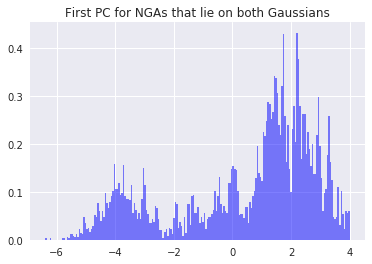

In [70]:
# histogram for NGAs that span both Gaussians

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# mean and covariance for each component
gauss_one = gmm.weights_[0] #weight for gaussian distribution
gauss_two = gmm.weights_[1] #weight for gaussian distribution 

idx_data = sorted(range(len(data[:,0])), key = lambda i: data[:,0][i]) #sort data points by their values on principal axis
prob_distr = gmm.predict_proba(X=np.expand_dims(sorted(data[:,0]), 1)) #probability distribution for gaussians on principal axis
lower = list()
higher = list()

for idx in range(len(prob_distr)):
    if gmm.weights_[0] < gmm.weights_[1]:
        if prob_distr[idx][0] >= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])
    else:
        if prob_distr[idx][0] <= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])

both_ngas = list()
# return polities that lie in both Gaussians for each imputed set
for i in range(1,21):
    impute = pnas_data1[pnas_data1.irep == i]
    lower_df = impute.loc[lower].dropna()
    higher_df = impute.loc[higher].dropna()

    unique_nga = [j for j in impute.NGA.unique().tolist() if (j in lower_df.NGA.unique().tolist()
                                                         and j in higher_df.NGA.unique().tolist())]
    nga_gauss = impute.loc[pnas_data1['NGA'].isin(unique_nga)]
    both_gauss = np.take(data[:,0], nga_gauss.index.values)
    both_ngas.append(both_gauss)

for i in range(len(both_ngas)-1):
    ngas = np.concatenate((both_ngas[i], both_ngas[i+1]), axis=0)
    both_ngas[i+1] = ngas
    
num_bins = 200

n, bins, patches = plt.hist(ngas, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('First PC for NGAs that lie on both Gaussians')
plt.legend()
plt.show()
plt.close()


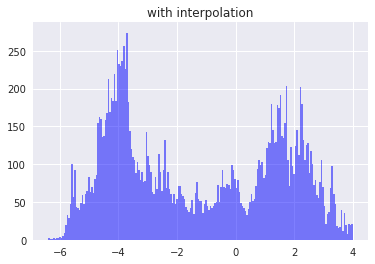

In [118]:
# linear interpolation of missing time periods 
added_rows = list()
for impute_step in range(1, 21):
    # interpolation for each imputation
    unique_region = pnas_data1.NGA.unique().tolist()
    
    for nga in unique_region:
        times = sorted(pnas_data1[pnas_data1.NGA == nga].Time.unique().tolist())
        if len(times) != ((max(times) - min(times))/100)+1:
            for time in range(len(times)-1):
                if times[time+1] - times[time] != 100:
                    
                    idx_val1 = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                               (pnas_data1.Time == times[time])].tolist()[0]
                    idx_val2 = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                               (pnas_data1.Time == times[time+1])].tolist()[0]
                    
                    diff = [i-j for i,j in zip(scaled[idx_val2], scaled[idx_val1])]
                    
                    num_steps = int((times[time+1]-times[time])/100)
                    
                    # linear interpolation
                    for i in range(1, num_steps):
                        diff_step = [(i/num_steps)*j for j in diff]
                        interpol = [k+l for k, l in zip(diff_step, scaled[idx_val1])]
                        
                        # check the validity of interpolation
                        for idx in range(len(interpol)):
                            assert ((interpol[idx] >= scaled[idx_val1, idx] and interpol[idx] < scaled[idx_val2, idx]) or
                                    (interpol[idx] < scaled[idx_val1, idx] and interpol[idx] >= scaled[idx_val2, idx]) or
                                    (interpol[idx] == scaled[idx_val1, idx] and interpol[idx] == scaled[idx_val2, idx]))
                            
                        added_rows.append(interpol)
                            
added_rows = np.asarray(added_rows)

assert added_rows.shape[1] == data_mat.shape[1]

data_matrix = np.vstack((scaled, added_rows)) # add interpolated rows to the original data matrix
proj = np.matmul(data_matrix, Q.T[:,0]) # project interpolated rows (as well as the original data) on principal axis
num_bins = 200

n, bins, patches = plt.hist(proj, num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('with interpolation')
plt.show()
plt.close()

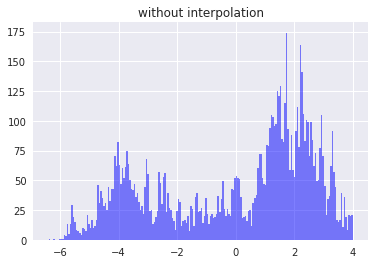

In [120]:
num_bins = 200
n, bins, patches = plt.hist(data[:,0], num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('without interpolation')
plt.show()
plt.close()

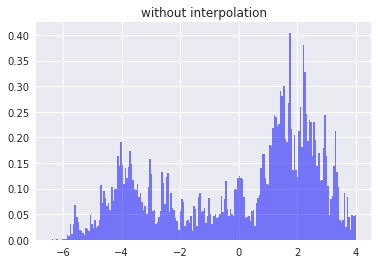

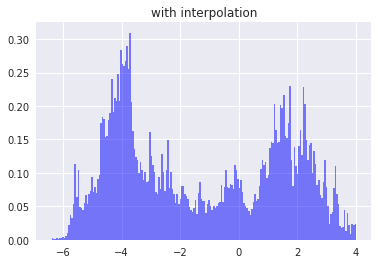

In [165]:
# check 9-d interpolation by doing interpolation on 1-d principal axis
num_bins = 200

n, bins, patches = plt.hist(data[:,0], num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('without interpolation')
plt.show()
plt.close()

# interpolating on the 1-d principal axis
period = [pnas_data1.loc[i]['Time'] for i in range(len(data[:,0]))]
added_rows = list()

for impute_step in range(1, 21):
    # 1) polity-based interpolation
    impute_set = pnas_data1[pnas_data1.irep==impute_step]
    unique_region = impute_set.NGA.unique().tolist()
    

    for nga in unique_region:
        times = sorted(impute_set[impute_set.NGA == nga].Time.unique().tolist())
        if len(times) != ((max(times)-min(times))/100)+1:
            for time in range(len(times)-1):
                if times[time+1]-times[time] != 100:
                    # linear interpolation
                    val1_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time]) &
                                                (pnas_data1['irep'] == impute_step)].tolist()[0]
                    val2_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time+1]) &
                                               (pnas_data1['irep'] == impute_step)].tolist()[0]

                    diff = data[:,0][val2_idx] - data[:,0][val1_idx]
                    
                    num_steps = int((times[time+1]-times[time])/100)

                    for i in range(1, num_steps):
                        diff_step = (i/num_steps)*diff
                        interpol = diff_step+data[:,0][val1_idx]
                        added_rows.append(interpol)
                        period.append(times[time]+100*i)

added_rows = np.asarray(added_rows)

pc_proj = np.concatenate((data[:,0], added_rows))

assert len(pc_proj) == len(period) 

n, bins, patches = plt.hist(pc_proj, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('with interpolation')
plt.show()
plt.close()



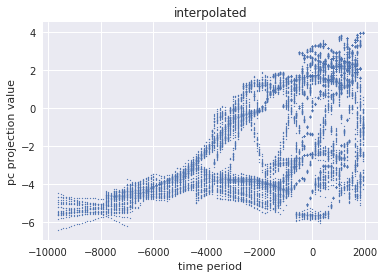

In [166]:
# scatter plot for interpolated data points
plt.scatter(period, pc_proj, s=1)
plt.title('interpolated')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

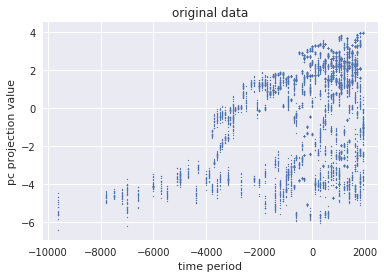

In [151]:
# scatter plot for original data points projected on the PC
orig_period = [pnas_data1.loc[i]['Time'] for i in range(len(data[:,0]))]
plt.scatter(orig_period, data[:,0], s=1)
plt.title('original data')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

In [158]:
print(len(pnas_data1[pnas_data1.NGA == 'Upper Egypt']['Time']))

780


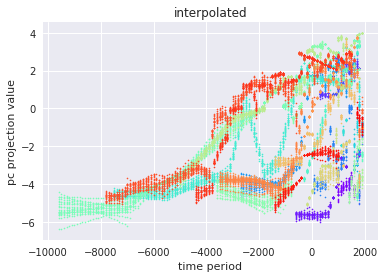

In [194]:
#9-d interpolation and scatter plot by NGAs

# interpolating on the 1-d principal axis
nga_interpolated = defaultdict(list)

for impute_step in range(1, 21):
    # 1) polity-based interpolation
    impute_set = pnas_data1[pnas_data1.irep==impute_step]
    unique_region = impute_set.NGA.unique().tolist()

    for nga in unique_region:
        times = sorted(impute_set[impute_set.NGA == nga].Time.unique().tolist())
        data_idx = list()
        for t in times: 
            data_idx.append(pnas_data1.index[(pnas_data1['NGA'] == nga) &
                                             (pnas_data1['Time'] == t) &
                                             (pnas_data1['irep'] == impute_step)].tolist()[0])
        nga_interpolated[nga].extend([(data[:,0][idx], time) for idx, time in zip(data_idx, times)])
        
        if len(times) != ((max(times)-min(times))/100)+1:
            for time in range(len(times)-1):
                if times[time+1]-times[time] != 100:
                    # linear interpolation
                    val1_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time]) &
                                                (pnas_data1['irep'] == impute_step)].tolist()[0]
                    val2_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time+1]) &
                                               (pnas_data1['irep'] == impute_step)].tolist()[0]

                    diff = data[:,0][val2_idx] - data[:,0][val1_idx]
                    
                    num_steps = int((times[time+1]-times[time])/100)

                    for i in range(1, num_steps):
                        diff_step = (i/num_steps)*diff
                        interpol = diff_step+data[:,0][val1_idx]
                        nga_interpolated[nga].append((interpol, times[time]+100*i))
    
ngas = pnas_data1.NGA.unique().tolist()
colors = iter(cm.rainbow(np.linspace(0, 1, len(ngas))))
for nga in ngas:
    period = [time for val, time in nga_interpolated[nga]]
    pc_proj = [val for val, time in nga_interpolated[nga]]
    plt.scatter(period, pc_proj, s=1.5, color=next(colors))
plt.title('interpolated')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

['Big Island Hawaii', 'Cahokia', 'Cambodian Basin', 'Central Java', 'Chuuk Islands', 'Cuzco', 'Deccan', 'Finger Lakes', 'Garo Hills', 'Ghanaian Coast']


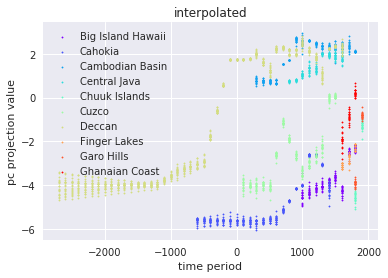

['Iceland', 'Kachi Plain', 'Kansai', 'Kapuasi Basin', 'Konya Plain', 'Latium', 'Lena River Valley', 'Lowland Andes', 'Middle Yellow River Valley', 'Niger Inland Delta']


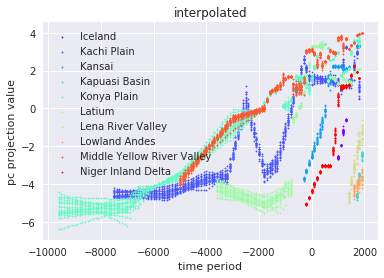

['North Colombia', 'Orkhon Valley', 'Oro PNG', 'Paris Basin', 'Sogdiana', 'Southern China Hills', 'Susiana', 'Upper Egypt', 'Valley of Oaxaca', 'Yemeni Coastal Plain']


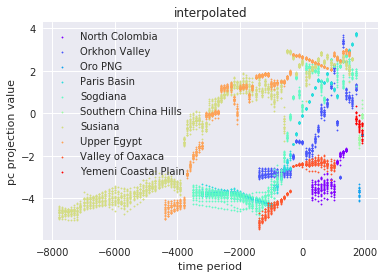

In [198]:
ngas = pnas_data1.NGA.unique().tolist()

for i in range(3):
    nga_split = ngas[10*i:10*i+10]
    print(nga_split)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(nga_split))))
    for nga in nga_split:
        period = [time for val, time in nga_interpolated[nga]]
        pc_proj = [val for val, time in nga_interpolated[nga]]
        plt.scatter(period, pc_proj, s=2, color=next(colors))
    plt.legend(nga_split)
    plt.title('interpolated')
    plt.xlabel('time period')
    plt.ylabel('pc projection value')
    plt.show()
    plt.close()


In [176]:
print([i for i in range(6, 36, 6)])
0 1 2 3 4

[6, 12, 18, 24, 30]
[1, 2]
